# Malaria Detection implementing VGG19
In this project, the goal is to detetct whether a person is suffering from Malaria or not implementing Transfer Learnig technique, VGG19.

In [1]:
!pip install tensorflow==2.5

     |████████████████████████████████| 454.3 MB 14 kB/s s eta 0:00:01  |▎                               | 4.5 MB 806 kB/s eta 0:09:18     |▊                               | 10.2 MB 806 kB/s eta 0:09:11     |██████████████████████████▊     | 378.9 MB 46.6 MB/s eta 0:00:02
     |████████████████████████████████| 4.0 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 19.9 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 51.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 12.5 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalli

In [2]:
import tensorflow as tf
tf.__version__

2021-09-16 21:36:05.795271: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


'2.5.0'

In [3]:
# Importing the necessary libraries

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Resizing all the images

IMAGE_SIZE = [224,224]

train_path = "../input/malaria/Sample Dataset/Train"
valid_path = "../input/malaria/Sample Dataset/Test"

In [5]:
# Inputting the VGG16 library and keeping the initial and final layer false as we dont want to classify 1000 categories. We have only two categories that is Pneumonia and not pneumonia.
# We are dropping the first layer too so that we can give our own image size
# The +3 is the RGB dimension that we need to add. Here we will be using imagenet weights.

vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights = "imagenet", include_top = False)

2021-09-16 21:37:37.960571: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-16 21:37:38.008089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 21:37:38.008700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-16 21:37:38.008785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-16 21:37:38.048168: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-16 21:37:38.048255: I tensorflow/stream_executor/plat

80142336/80134624 [==============================] - 1s 0us/step


In [6]:
# We should not train the existing weights otherwise the weights that we captured will get changed

for layer in vgg.layers:
  layer.trainable = False

In [7]:
# Lets check the number of output classes

folders = glob("../input/malaria/Sample Dataset/Train/*")

In [8]:
# Our layers - we can add more if we want. Here we will flatten the existing layers

x = Flatten()(vgg.output)

In [9]:
# Lets create the output layer
prediction = Dense(len(folders), activation = "softmax")(x)

# Creating a model object
model = Model(inputs = vgg.input, outputs = prediction)

In [10]:
# Lets see the model summary

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# Compiling the model - telling the model what cost and optimizatiom method to use

model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [12]:
# Using the ImageDataGenerator to import the images from the dataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Making sure that we provide the same target size as initialized for the image size -- passing the train images to our model

training_set = train_datagen.flow_from_directory("../input/malaria/Sample Dataset/Train",
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = "categorical")

Found 416 images belonging to 2 classes.


In [14]:
# Passing the test images to our model

test_set = test_datagen.flow_from_directory("../input/malaria/Sample Dataset/Test",
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = "categorical")

Found 134 images belonging to 2 classes.


In [17]:
# Model Fitting

r = model.fit_generator(training_set, validation_data = test_set, epochs = 25, steps_per_epoch = len(training_set), validation_steps = len(test_set))

Epoch 1/25
13/13 [==============================] - 174s 14s/step - loss: 0.1676 - accuracy: 0.9543 - val_loss: 0.2594 - val_accuracy: 0.9104
Epoch 2/25
13/13 [==============================] - 175s 14s/step - loss: 0.1739 - accuracy: 0.9423 - val_loss: 0.4795 - val_accuracy: 0.7313
Epoch 3/25
13/13 [==============================] - 177s 14s/step - loss: 0.2161 - accuracy: 0.9231 - val_loss: 0.3600 - val_accuracy: 0.7761
Epoch 4/25
13/13 [==============================] - 176s 14s/step - loss: 0.2404 - accuracy: 0.9111 - val_loss: 0.7305 - val_accuracy: 0.6716
Epoch 5/25
13/13 [==============================] - 180s 14s/step - loss: 0.2707 - accuracy: 0.8798 - val_loss: 0.2871 - val_accuracy: 0.8507
Epoch 6/25
13/13 [==============================] - 172s 13s/step - loss: 0.1791 - accuracy: 0.9303 - val_loss: 0.3063 - val_accuracy: 0.8507
Epoch 7/25
13/13 [==============================] - 172s 13s/step - loss: 0.1336 - accuracy: 0.9712 - val_loss: 0.3435 - val_accuracy: 0.8134
Epoch 

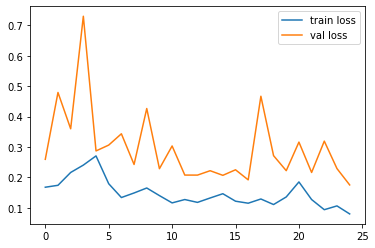

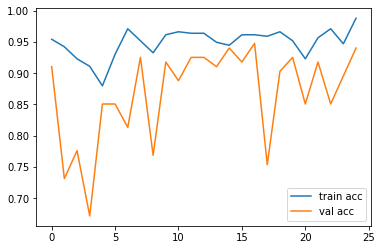

<Figure size 432x288 with 0 Axes>

In [18]:
# Plotting the loss
plt.plot(r.history["loss"], label = "train loss")
plt.plot(r.history["val_loss"], label = "val loss")
plt.legend()
plt.show();
plt.savefig("LossVal_loss")

# Plotting the accuracy
plt.plot(r.history["accuracy"], label = "train acc")
plt.plot(r.history["val_accuracy"], label = "val acc")
plt.legend()
plt.show();
plt.savefig("AccVal_acc")

In [19]:
# Saving the model to reuse it later

from tensorflow.keras.models import load_model
model.save("model_vgg19.h5")